In [1]:
# STEP 1: Install torch dan torchvision versi yang kompatibel (CUDA 11.8)
!pip install torch==2.0.1 torchvision==0.15.2 torchaudio==2.0.2 --index-url https://download.pytorch.org/whl/cu118

# STEP 2: Install PyTorch Geometric dan dependensinya (harus urut)
!pip install torch-scatter -f https://data.pyg.org/whl/torch-2.0.0+cu118.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-2.0.0+cu118.html
!pip install torch-geometric

# STEP 3: Install library tambahan yang dibutuhkan
!pip install timm pillow matplotlib h5py pandas networkx
!pip install numpy==1.26.4


Looking in indexes: https://download.pytorch.org/whl/cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 GB ? eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 108.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 96.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 MB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 87.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.3/132.3 kB 8.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for lit: filename=lit-15.0.7-py3-none-any.whl size=89991 sha256=84bd954d2e8126f3f7bf45c8a910f24e90b4ca02d32099fd51b8c454fc7a4452
  Stored in directory: /root/.cache/pip/wheels/fc/5d/45/34fe9945d5e45e261134e72284395be36c2d4828af38e2b0fe
Successfully built lit
  Attempting uninstall: torch
    Found existing installat

In [1]:
!pip install numpy==1.26.4


In [6]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
from PIL import Image

img = Image.open("/content/drive/MyDrive/samples/Estetik/002_00103.jpg")
img_array = np.array(img)

print("Gambar berhasil diproses dengan numpy versi:", np.__version__)
print("Ukuran array:", img_array.shape)


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/samples/Estetik/002_00103.jpg'

# GCN Dataset Builder with CNN + Warna per Patch

In [ ]:
import torch
import timm
import torchvision.transforms as transforms
from PIL import Image, ImageOps
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import os
import h5py
import pandas as pd
import gc
from torch_geometric.data import Data, DataLoader

# Load model CNN pretrained dari TIMM
model = timm.create_model('inception_resnet_v2', pretrained=True, features_only=True)
model.eval()


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/224M [00:00<?, ?B/s]

FeatureListNet(
  (conv2d_1a): ConvNormAct(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNormAct2d(
      32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): ReLU(inplace=True)
    )
  )
  (conv2d_2a): ConvNormAct(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNormAct2d(
      32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): ReLU(inplace=True)
    )
  )
  (conv2d_2b): ConvNormAct(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNormAct2d(
      64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): ReLU(inplace=True)
    )
  )
  (maxpool_3a): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2d_3b): ConvNormAct(
    (conv): Conv2d(64, 80, kernel_size=(1, 1),

In [ ]:
def load_image(image_path, target_size=(288, 288)):
    image = Image.open(image_path).convert("RGB")
    original_size = image.size

    # Resize sambil mempertahankan rasio aspek
    image.thumbnail(target_size, Image.LANCZOS)

    # Hitung padding yang diperlukan
    delta_w = target_size[0] - image.size[0]
    delta_h = target_size[1] - image.size[1]

    # Hitung warna rata-rata dari gambar
    mean_color = tuple(np.array(image).reshape(-1, 3).mean(axis=0).astype(int))

    # Tambahkan padding dengan warna rata-rata
    padding = (delta_w // 2, delta_h // 2, delta_w - delta_w // 2, delta_h - delta_h // 2)
    image = ImageOps.expand(image, padding, fill=mean_color)

    return image, original_size

In [ ]:
image, ori_size = load_image("/content/drive/MyDrive/samples/contoh/002_00103.jpg")
image.show()
print(f"Original size: {ori_size} → Resized to: {image.size}")

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/samples/contoh/002_00103.jpg'

In [ ]:
nva

In [9]:
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import numpy as np
import os

# Fungsi untuk praproses gambar
def load_image(image_path, target_size=(288, 288)):
    image = Image.open(image_path).convert("RGB")
    image.thumbnail(target_size, Image.LANCZOS)
    delta_w = target_size[0] - image.size[0]
    delta_h = target_size[1] - image.size[1]
    mean_color = tuple(np.array(image).reshape(-1, 3).mean(axis=0).astype(int))
    padding = (delta_w // 2, delta_h // 2, delta_w - delta_w // 2, delta_h - delta_h // 2)
    image = ImageOps.expand(image, padding, fill=mean_color)
    return image

# Daftar file gambar
image_ids = [1, 6, 41, 49, 58, 80, 111, 136, 201, 747]
image_files = [f"{i}.jpg" for i in image_ids]
root_path = '/content/drive/MyDrive/samples/contoh/'

# Validasi jumlah gambar
if len(image_files) % 2 != 0:
    raise ValueError("Jumlah gambar harus genap agar layout bisa 2 kiri - 2 kanan")

num_rows = len(image_files) // 2  # 2 gambar per baris
fig, axes = plt.subplots(num_rows, 5, figsize=(13, num_rows * 3),
                         gridspec_kw={'width_ratios': [1, 1, 1, 1, 1]},
                         squeeze=False)

for row in range(num_rows):
    for j in range(2):
        idx = row * 2 + j
        img_path = os.path.join(root_path, image_files[idx])

        # Kolom 0 & 1 = gambar asli
        original = Image.open(img_path).convert("RGB")
        axes[row, j].imshow(original)
        axes[row, j].axis("off")
        axes[row, j].set_title(f"{image_files[idx]} (Asli)", fontsize=9)

        # Kolom 2 = garis pemisah
        axes[row, 2].axis("off")
        axes[row, 2].plot([0.5, 0.5], [0, 1], transform=axes[row, 2].transAxes,
                          color='black', linewidth=1)

        # Kolom 3 & 4 = gambar praproses
        processed = load_image(img_path)
        axes[row, j + 3].imshow(processed)
        axes[row, j + 3].axis("off")
        axes[row, j + 3].set_title(f"{image_files[idx]} (Praproses)", fontsize=9)

# Label bawah
fig.text(0.22, 0.04, '(a) ', ha='center', fontsize=12)
fig.text(0.78, 0.04, '(b) ', ha='center', fontsize=12)

plt.tight_layout(rect=[0, 0.07, 1, 1])
plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
plt.tight_layout(rect=[0, 0.07, 1, 1])

plt.savefig("hasil_visual_gambar.png", dpi=300, bbox_inches='tight')  # <-- SAVE DULU

plt.show()  # <-- BARU TAMPILKAN


<Figure size 640x480 with 0 Axes>

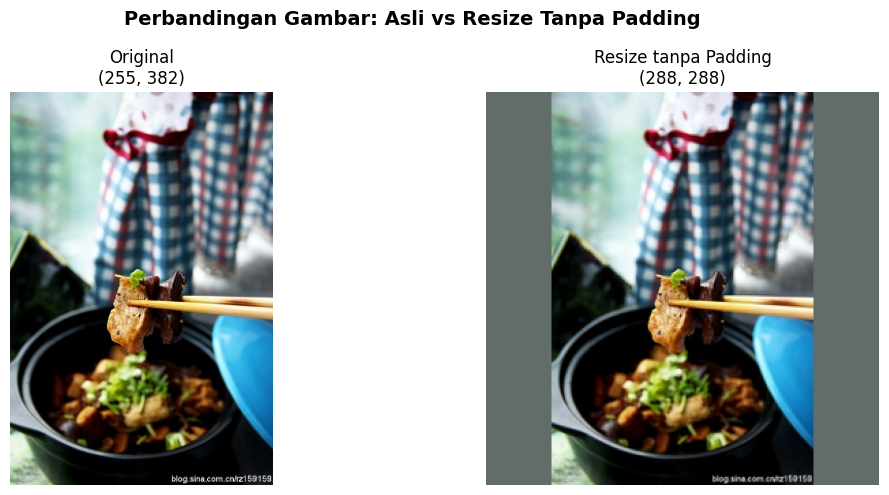

In [ ]:
import matplotlib.pyplot as plt
# Path gambar
img_path = "samples/Estetik_2/004_00212.jpg"

# Proses gambar
original_img = Image.open(img_path).convert("RGB")
resized_img, ori_size = load_image(img_path)

# Tampilkan perbandingan
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].imshow(original_img)
axs[0].set_title(f"Original\n{original_img.size}", fontsize=12)
axs[0].axis("off")

axs[1].imshow(resized_img)
axs[1].set_title(f"Resize tanpa Padding\n{resized_img.size}", fontsize=12)
axs[1].axis("off")

plt.suptitle("Perbandingan Gambar: Asli vs Resize Tanpa Padding", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

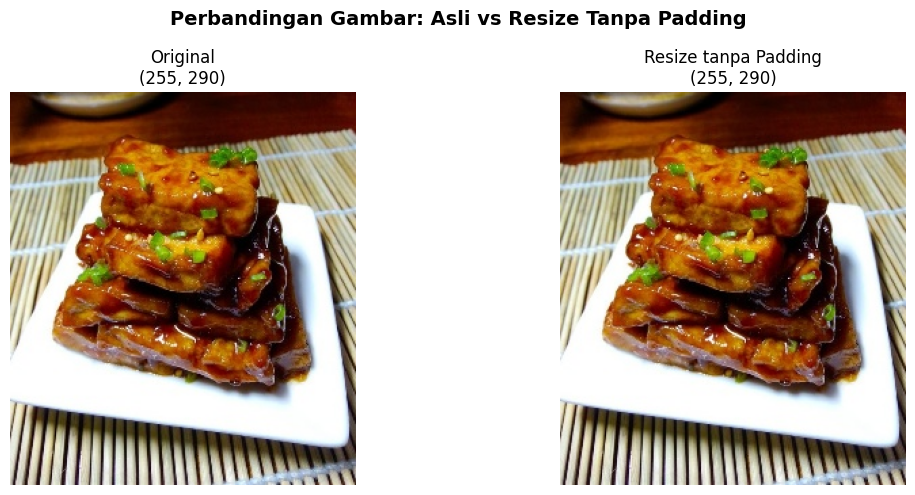

In [ ]:
import matplotlib.pyplot as plt
# Path gambar
img_path = "samples/Estetik_2/002_10063.jpg"

# Proses gambar
original_img = Image.open(img_path).convert("RGB")
resized_img, ori_size = load_image(img_path)

# Tampilkan perbandingan
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].imshow(original_img)
axs[0].set_title(f"Original\n{original_img.size}", fontsize=12)
axs[0].axis("off")

axs[1].imshow(resized_img)
axs[1].set_title(f"Resize tanpa Padding\n{resized_img.size}", fontsize=12)
axs[1].axis("off")

plt.suptitle("Perbandingan Gambar: Asli vs Resize Tanpa Padding", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

8x8 - Jumlah Node: 64, Dimensi per Node: 3200


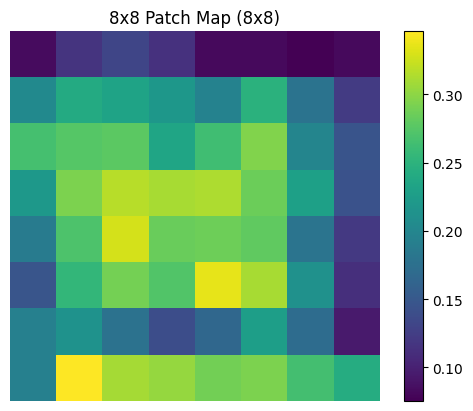

3x3 - Jumlah Node: 9, Dimensi per Node: 3200


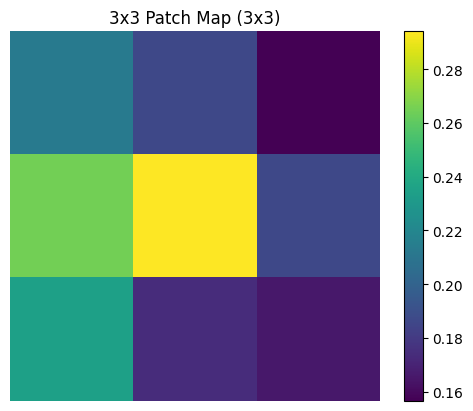

In [ ]:
from PIL import Image
import torchvision.transforms as transforms
import torch
import timm
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

# Load image
img_path = "samples/Estetik_2/002_10063.jpg"
image = Image.open(img_path).convert("RGB")
transform_tensor = transforms.Compose([transforms.Resize((299, 299)), transforms.ToTensor()])
image_tensor = transform_tensor(image).unsqueeze(0)

# Load CNN
model = timm.create_model('inception_resnet_v2', pretrained=True, features_only=True)
model.eval()

# Ekstraksi fitur
with torch.no_grad():
    feature_maps = model(image_tensor)

def extract_and_plot(features, patch_size=(8,8), title="Patch"):
    # Resize tiap feature map ke ukuran patch yang diinginkan
    resized = [F.interpolate(f, size=patch_size, mode='bilinear', align_corners=False) for f in features]
    combined = torch.cat(resized, dim=1).squeeze(0)  # (C, H, W)

    node_features = combined.permute(1, 2, 0).reshape(-1, combined.shape[0])  # (num_nodes, D)
    print(f"{title} - Jumlah Node: {node_features.shape[0]}, Dimensi per Node: {node_features.shape[1]}")

    # Visualisasi grid
    grid_feat = combined.mean(0)  # (H, W)
    plt.imshow(grid_feat.cpu(), cmap='viridis')
    plt.title(f"{title} Patch Map ({patch_size[0]}x{patch_size[1]})")
    plt.colorbar()
    plt.axis('off')
    plt.show()

# 🔹 8x8 Patch (Default)
extract_and_plot(feature_maps, patch_size=(8, 8), title="8x8")

# 🔸 3x3 Patch
extract_and_plot(feature_maps, patch_size=(3, 3), title="3x3")


In [ ]:
def extract_features(image_tensor, model):
    model.eval()
    with torch.no_grad():
        feature_maps = model(image_tensor)
    target_W, target_H = feature_maps[-1].shape[2], feature_maps[-1].shape[3]

    resized_features = [
        torch.nn.functional.interpolate(f, size=(target_W, target_H), mode='bilinear', align_corners=False)
        for f in feature_maps
    ]
    features = torch.cat(resized_features, dim=1).squeeze(0)
    return features, target_W, target_H


PATCH SIZE 3X3

In [ ]:
def extract_features(image_tensor, model, patch_size=(3, 3), selected_layers=[1, 3, 4]):
    model.eval()
    with torch.no_grad():
        all_features = model(image_tensor)  # list of tensors

    # Ambil hanya level yang dipilih
    selected_features = [all_features[i] for i in selected_layers]

    # Resize ke patch grid (3x3)
    resized = [
        torch.nn.functional.interpolate(f, size=patch_size, mode='bilinear', align_corners=False)
        for f in selected_features
    ]

    features = torch.cat(resized, dim=1).squeeze(0)  # (C_total, H, W)

    return features, patch_size[0], patch_size[1]


In [ ]:
def extract_features(image_tensor, model, patch_size=(3, 3), selected_layers=[1, 3, 4]):
    model.eval()
    with torch.no_grad():
        all_features = model(image_tensor)  # list of tensors

    print("🔍 [extract_features] Cek layer output (mean dan std):")
    for i, f in enumerate(all_features):
        print(f"  Layer {i}: shape={tuple(f.shape)}, mean={f.mean().item():.4f}, std={f.std().item():.4f}")

    # Ambil hanya level yang dipilih
    selected_features = [all_features[i] for i in selected_layers]

    # Resize ke patch grid (3x3)
    resized = [
        torch.nn.functional.interpolate(f, size=patch_size, mode='bilinear', align_corners=False)
        for f in selected_features
    ]

    # Gabungkan semua channel dari layer terpilih
    features = torch.cat(resized, dim=1).squeeze(0)  # (C_total, H, W)

    # Debug fitur final per node
    flat = features.permute(1, 2, 0).reshape(-1, features.shape[0])  # (H*W, C_total)
    print(f"🔎 Fitur akhir shape: {flat.shape}")
    print(f"  Node 0 summary: mean={flat[0].mean().item():.4f}, std={flat[0].std().item():.4f}")
    print(f"  Node 1 summary: mean={flat[1].mean().item():.4f}, std={flat[1].std().item():.4f}")

    return features, patch_size[0], patch_size[1]


In [ ]:
def create_feature_graph(features, W, H):
    D = features.shape[0]
    feature_map = features.view(D, W * H).T.numpy()
    G = nx.Graph()
    for i in range(W * H):
        G.add_node(i, feature=feature_map[i])
    for x in range(W):
        for y in range(H):
            node_idx = x * H + y
            neighbors = [(x+dx, y+dy) for dx, dy in [(-1,0), (1,0), (0,-1), (0,1)]]
            for nx_, ny_ in neighbors:
                if 0 <= nx_ < W and 0 <= ny_ < H:
                    neighbor_idx = nx_ * H + ny_
                    G.add_edge(node_idx, neighbor_idx)
    return G


### MEANGAMBIL MEAN DAN STANDART DEVIASI

In [ ]:
from scipy.stats import skew  # untuk color moment ke-3

def compute_color_moments(patch):
    moments = []
    for c in range(3):  # R, G, B
        channel = patch[:, :, c].flatten()
        moments.append(np.mean(channel))
        moments.append(np.std(channel))
        moments.append(skew(channel))
    return moments  # total 9 dimensi (3 momen × 3 channel)

In [ ]:
def extract_color_moments(pil_image, grid_size=(3, 3)):
    img_np = np.array(pil_image)  # Asumsi sudah resize + padding
    patch_h = img_np.shape[0] // grid_size[1]
    patch_w = img_np.shape[1] // grid_size[0]

    color_moments = []
    for i in range(grid_size[1]):
        for j in range(grid_size[0]):
            patch = img_np[i*patch_h:(i+1)*patch_h, j*patch_w:(j+1)*patch_w, :]
            cm = compute_color_moments(patch)
            color_moments.append(cm)
    return np.array(color_moments)  # shape: [num_patches, 6]

In [ ]:

import os
os.makedirs('/content/drive/MyDrive/Hasil_Ekstraksi', exist_ok=True)


In [ ]:
def save_graphs_with_color_moments(dataset_path,
                                   csv_filename="graph_dataset_samples.csv",
                                   log_filename="log_gagal_baru.txt"):

    csv_path = os.path.join('/content/drive/MyDrive/Hasil_Ekstraksi', csv_filename)
    log_path = os.path.join('/content/drive/MyDrive/Hasil_Ekstraksi', log_filename)

    transform_tensor = transforms.Compose([transforms.ToTensor()])
    total_ok = 0
    total_fail = 0

    # Hapus file lama jika ada
    if os.path.exists(csv_path):
        os.remove(csv_path)
    if os.path.exists(log_path):
        os.remove(log_path)

    with open(log_path, 'w') as log_file:
        log_file.write("Log Gambar Gagal Diproses:\n")

        with torch.no_grad():
            for label, category in enumerate(["tidak_estetik", "estetik"]):
                category_path = os.path.join(dataset_path, category)
                for filename in sorted(os.listdir(category_path)):
                    if not filename.lower().endswith(('.jpg', '.jpeg', '.png')):
                        continue

                    try:
                        image_path = os.path.join(category_path, filename)
                        pil_image, original_size = load_image(image_path)
                        image_tensor = transform_tensor(pil_image).unsqueeze(0)
                        features, W, H = extract_features(image_tensor, model)

                        feature_graph = create_feature_graph(features, W, H)
                        cnn_features = np.array([feature_graph.nodes[n]['feature'] for n in feature_graph.nodes])
                        color_moment_features = extract_color_moments(pil_image, grid_size=(W, H))

                        # Tambahkan fitur posisi (x, y) & rasio aspek
                        positions = []
                        rasio_aspek = original_size[0] / original_size[1]

                        for idx in range(H * W):
                            y = idx // W
                            x = idx % W
                            x_norm = x / (W - 1) if W > 1 else 0.0
                            y_norm = y / (H - 1) if H > 1 else 0.0
                            positions.append([x_norm, y_norm, rasio_aspek])

                        positions = np.array(positions)
                        combined = np.concatenate([cnn_features, color_moment_features, positions], axis=1)
                        # 🔍 Debug fitur per node (misalnya Node 0) sebelum simpan ke CSV
                        node0 = combined[0]
                        print(f"🔍 {filename} | Node 0 mean: {node0.mean():.4f}, std: {node0.std():.4f}")

                        edge_index = torch.tensor(list(feature_graph.edges)).t().contiguous()
                        graph_data = Data(
                            x=torch.tensor(combined, dtype=torch.float),
                            edge_index=edge_index,
                            y=torch.tensor([label], dtype=torch.long)
                        )

                        df_temp = pd.DataFrame([[filename, category, W, H, original_size[0], original_size[1],
                                                 graph_data.x.tolist(),
                                                 graph_data.edge_index.numpy().tolist(),
                                                 color_moment_features.tolist()]],
                                               columns=['Filename', 'Category', 'W', 'H',
                                                        'Original_Width', 'Original_Height',
                                                        'Node_Features', 'Edge_Index', 'Color_Features'])

                        # Tulis CSV (mode='a' hanya karena kita tulis row per row, tapi header hanya ditulis di awal)
                        mode = 'w' if total_ok == 0 else 'a'
                        df_temp.to_csv(csv_path, mode=mode, header=(total_ok == 0), index=False)
                        total_ok += 1

                        print(f"✔️ {filename} | Fitur: {combined.shape[1]}")

                        del graph_data, cnn_features, color_moment_features, combined
                        gc.collect()
                        torch.cuda.empty_cache()

                    except Exception as e:
                        print(f"⚠️ Error processing {filename}: {e}")
                        log_file.write(f"{filename} ({category}) - {e}\n")
                        total_fail += 1

    print(f"\n📁 Dataset CSV baru disimpan di: {csv_path}")
    print(f"✅ Total berhasil: {total_ok}")
    print(f"❌ Total gagal: {total_fail}")
    print(f"📝 Log error: {log_path}")


DENGAN PENGECEKAN FILE YANG ADA

In [ ]:
def save_graphs_with_color_moments(dataset_path,
                                   csv_filename="graph_dataset_with_color_moment_fix.csv",
                                   log_filename="log_gagal.txt",
                                   gambar_berhasil_path="/content/drive/MyDrive/Hasil_Ekstraksi/gambar_berhasil.csv"):

    csv_path = os.path.join('/content/drive/MyDrive/Hasil_Ekstraksi', csv_filename)
    log_path = os.path.join('/content/drive/MyDrive/Hasil_Ekstraksi', log_filename)

    if os.path.exists(gambar_berhasil_path):
        gambar_berhasil_df = pd.read_csv(gambar_berhasil_path)
        gambar_sudah_ada = set(gambar_berhasil_df['Filename'].dropna().tolist())
    else:
        gambar_sudah_ada = set()

    transform_tensor = transforms.Compose([transforms.ToTensor()])
    first_write = not os.path.exists(csv_path)
    total_ok = 0
    total_fail = 0

    with open(log_path, 'a') as log_file:
        log_file.write("\nLog Tambahan Gambar Gagal Diproses:\n")

        with torch.no_grad():
            for label, category in enumerate(["tidak_estetik", "estetik"]):
                category_path = os.path.join(dataset_path, category)
                for idx, filename in enumerate(os.listdir(category_path)):
                    if not filename.lower().endswith(('.jpg', '.jpeg', '.png')):
                        continue

                    if filename in gambar_sudah_ada:
                        print(f"⏩ Lewati {filename} (sudah ada)")
                        continue

                    try:
                        image_path = os.path.join(category_path, filename)
                        pil_image, original_size = load_image(image_path)
                        image_tensor = transform_tensor(pil_image).unsqueeze(0)
                        features, W, H = extract_features(image_tensor, model)

                        # Inisialisasi graph
                        feature_graph = create_feature_graph(features, W, H)
                        cnn_features = np.array([feature_graph.nodes[n]['feature'] for n in feature_graph.nodes])
                        color_moment_features = extract_color_moments(pil_image, grid_size=(W, H))

                        # Tambahkan fitur posisi (x, y) & rasio aspek
                        positions = []
                        rasio_aspek = original_size[0] / original_size[1]  # width / height

                        for idx in range(H * W):
                            y = idx // W
                            x = idx % W
                            x_norm = x / (W - 1) if W > 1 else 0.0
                            y_norm = y / (H - 1) if H > 1 else 0.0
                            positions.append([x_norm, y_norm, rasio_aspek])

                        positions = np.array(positions)
                        combined = np.concatenate([cnn_features, color_moment_features, positions], axis=1)

                        edge_index = torch.tensor(list(feature_graph.edges)).t().contiguous()
                        graph_data = Data(
                            x=torch.tensor(combined, dtype=torch.float),
                            edge_index=edge_index,
                            y=torch.tensor([label], dtype=torch.long)
                        )

                        df_temp = pd.DataFrame([[filename, category, W, H, original_size[0], original_size[1],
                                                 graph_data.x.tolist(),
                                                 graph_data.edge_index.numpy().tolist(),
                                                 color_moment_features.tolist()]],
                                               columns=['Filename', 'Category', 'W', 'H',
                                                        'Original_Width', 'Original_Height',
                                                        'Node_Features', 'Edge_Index', 'Color_Features'])

                        df_temp.to_csv(csv_path, mode='a', header=first_write, index=False)
                        first_write = False
                        total_ok += 1

                        print(f"✔️ {filename} | CNN+CM+Pos: {combined.shape[1]} fitur")

                        del graph_data, cnn_features, color_moment_features, combined
                        gc.collect()
                        torch.cuda.empty_cache()

                    except Exception as e:
                        print(f"⚠️ Error processing {filename}: {e}")
                        log_file.write(f"{filename} ({category}) - {e}\n")
                        total_fail += 1

    print(f"\n📁 Dataset CSV disimpan di: {csv_path}")
    print(f"✅ Total gambar baru diproses: {total_ok}")
    print(f"❌ Total gagal: {total_fail}")
    print(f"📝 Log error: {log_path}")


In [ ]:
import numpy as np
print("✅ Numpy ready:", np.__version__)


✅ Numpy ready: 1.26.4


In [ ]:
# Jalankan pipeline
dataset_path = '/content/drive/MyDrive/samples/contoh'
save_graphs_with_color_moments(dataset_path)

🔍 [extract_features] Cek layer output (mean dan std):
  Layer 0: shape=(1, 64, 141, 141), mean=0.5796, std=0.7340
  Layer 1: shape=(1, 192, 68, 68), mean=0.4433, std=0.7426
  Layer 2: shape=(1, 320, 33, 33), mean=0.1778, std=0.2050
  Layer 3: shape=(1, 1088, 16, 16), mean=0.0103, std=0.0541
  Layer 4: shape=(1, 1536, 7, 7), mean=0.4265, std=0.8700
🔎 Fitur akhir shape: torch.Size([9, 2816])
  Node 0 summary: mean=0.1510, std=0.3493
  Node 1 summary: mean=0.1641, std=0.3472
🔍 1.jpg | Node 0 mean: 0.3501, std: 5.6260
✔️ 1.jpg | Fitur: 2828
🔍 [extract_features] Cek layer output (mean dan std):
  Layer 0: shape=(1, 64, 141, 141), mean=0.5752, std=0.7445
  Layer 1: shape=(1, 192, 68, 68), mean=0.4652, std=0.7783
  Layer 2: shape=(1, 320, 33, 33), mean=0.1781, std=0.1960
  Layer 3: shape=(1, 1088, 16, 16), mean=0.0099, std=0.0524
  Layer 4: shape=(1, 1536, 7, 7), mean=0.4870, std=0.9091
🔎 Fitur akhir shape: torch.Size([9, 2816])
  Node 0 summary: mean=0.0823, std=0.3510
  Node 1 summary: mean

In [ ]:
from google.colab import drive
drive.mount('/content/drive')




Mounted at /content/drive


In [ ]:
import pandas as pd
import ast

# Baca file CSV
df = pd.read_csv("/content/drive/MyDrive/Hasil_Ekstraksi/graph_dataset_samples.csv")

# Ambil informasi untuk satu gambar (baris pertama)
filename = df["Filename"].iloc[9]
node_features = ast.literal_eval(df["Color_Features"].iloc[9])  # Konversi string ke list

# Cetak nama file
print(f"📂 Filename: {filename}")
print(f"📌 Jumlah Node: {len(node_features)}\n")

# Tampilkan semua fitur untuk setiap node
for i, node in enumerate(node_features):
    print(f"🧩 Fitur Node {i}:")
    print(node)
    print("-" * 50)


📂 Filename: 747.jpg
📌 Jumlah Node: 9

🧩 Fitur Node 0:
[168.60188802083334, 22.720190728686173, 0.030127016136209175, 160.23990885416666, 24.301970731101285, 0.014849194531080648, 157.60036892361111, 23.660827566858636, 0.015041459027031821]
--------------------------------------------------
🧩 Fitur Node 1:
[169.82931857638889, 23.86400024322365, 0.008622517301481178, 160.943359375, 24.971112723686225, 0.006650674336525662, 158.40646701388889, 24.433622025010227, 0.006645716825386353]
--------------------------------------------------
🧩 Fitur Node 2:
[167.92122395833334, 22.02583613690304, 0.027697567085295666, 158.93576388888889, 23.032213373635976, 0.024547347558852434, 156.39398871527777, 22.505575184502376, 0.02859703926976825]
--------------------------------------------------
🧩 Fitur Node 3:
[156.2109375, 32.8450069426928, -1.4429284995819884, 139.11241319444446, 30.155016778055785, -1.261459967050987, 136.95203993055554, 27.15041532393739, -1.2133770608871428]
-------------------

In [ ]:
import pandas as pd
import ast
import numpy as np

# Baca file CSV
df = pd.read_csv("/content/drive/MyDrive/Hasil_Ekstraksi/graph_dataset_samples.csv")

# Ambil informasi untuk satu gambar (baris ke-3)
filename = df["Filename"].iloc[2]
node_features = ast.literal_eval(df["Node_Features"].iloc[2])  # perhatikan indeksnya harus sama

# Cetak nama file dan jumlah node
print(f"📂 Filename: {filename}")
print(f"📌 Jumlah Node: {len(node_features)}\n")

# Tampilkan semua fitur untuk setiap node beserta mean dan std
for i, node in enumerate(node_features):
    node_array = np.array(node)
    mean_val = np.mean(node_array)
    std_val = np.std(node_array)
    print(f"🧩 Fitur Node {i}:")
    print(node_array)
    print(f"   🔹 Mean: {mean_val:.4f} | Std: {std_val:.4f}")
    print("-" * 60)


📂 Filename: 49.jpg
📌 Jumlah Node: 9

🧩 Fitur Node 0:
[0.08183856 0.         1.55253565 ... 0.         0.         0.66579634]
   🔹 Mean: 0.2662 | Std: 4.3126
------------------------------------------------------------
🧩 Fitur Node 1:
[0.32863405 0.         2.81751776 ... 0.5        0.         0.66579634]
   🔹 Mean: 0.6311 | Std: 4.9426
------------------------------------------------------------
🧩 Fitur Node 2:
[1.29602849 0.         1.46915901 ... 1.         0.         0.66579634]
   🔹 Mean: 0.2705 | Std: 3.7734
------------------------------------------------------------
🧩 Fitur Node 3:
[1.69092953 0.         3.01558423 ... 0.         0.5        0.66579634]
   🔹 Mean: 0.3257 | Std: 6.0538
------------------------------------------------------------
🧩 Fitur Node 4:
[0.95114386 0.         3.31428981 ... 0.5        0.5        0.66579634]
   🔹 Mean: 0.6723 | Std: 6.9802
------------------------------------------------------------
🧩 Fitur Node 5:
[0.27137989 0.         3.00951958 ... 1.  

In [ ]:
import pandas as pd
import ast

# Baca file CSV
df = pd.read_csv("/content/drive/MyDrive/Hasil_Ekstraksi/graph_dataset_samples.csv")

# Ambil informasi untuk satu gambar (baris pertama)
filename = df["Filename"].iloc[2]
node_features = ast.literal_eval(df["Node_Features"].iloc[0])  # Konversi string ke list

# Cetak nama file
print(f"📂 Filename: {filename}")
print(f"📌 Jumlah Node: {len(node_features)}\n")

# Tampilkan semua fitur untuk setiap node
for i, node in enumerate(node_features):
    print(f"🧩 Fitur Node {i}:")
    print(node)
    print("-" * 50)


📂 Filename: 49.jpg
📌 Jumlah Node: 9

🧩 Fitur Node 0:
[0.21775783598423004, 0.0, 2.6765453815460205, 0.04245154559612274, 0.15037164092063904, 0.0, 0.0, 0.0, 0.009953344240784645, 0.0, 0.2897590100765228, 0.0, 1.0919021368026733, 0.0, 0.0, 0.0, 0.26704004406929016, 0.0, 0.0, 0.0, 0.007089311722666025, 0.0, 0.8005142211914062, 1.026426911354065, 0.1341371238231659, 0.17952841520309448, 0.0, 0.0, 0.0, 0.009400753304362297, 0.0, 0.0, 0.07814962416887283, 0.781812310218811, 0.26533427834510803, 0.020802276208996773, 0.6307098269462585, 0.0, 1.6222940683364868, 0.03275952488183975, 0.0, 0.17765328288078308, 0.0, 0.20683543384075165, 0.002431653905659914, 0.0, 1.1724045276641846, 0.0, 2.31882905960083, 0.0, 0.0, 0.4128432273864746, 0.12386630475521088, 1.5497475862503052, 0.0, 0.45314326882362366, 0.0, 0.0, 0.2837355136871338, 0.36428436636924744, 0.0, 0.8133562803268433, 0.29775962233543396, 0.0, 0.0, 0.27049994468688965, 0.3454446494579315, 2.0240421295166016, 0.506663978099823, 0.095472007

In [ ]:
import pandas as pd
import ast

# Baca file CSV
df = pd.read_csv("/content/drive/MyDrive/Hasil_Ekstraksi/graph_dataset_samples.csv")

# Ambil informasi untuk satu gambar (baris pertama)
filename = df["Filename"].iloc[8]
node_features = ast.literal_eval(df["Node_Features"].iloc[0])  # Konversi string ke list

# Cetak nama file
print(f"📂 Filename: {filename}")
print(f"📌 Jumlah Node: {len(node_features)}\n")

# Tampilkan semua fitur untuk setiap node
for i, node in enumerate(node_features):
    print(f"🧩 Fitur Node {i}:")
    print(node)
    print("-" * 50)


📂 Filename: 201.jpg
📌 Jumlah Node: 9

🧩 Fitur Node 0:
[0.21775783598423004, 0.0, 2.6765453815460205, 0.04245154559612274, 0.15037164092063904, 0.0, 0.0, 0.0, 0.009953344240784645, 0.0, 0.2897590100765228, 0.0, 1.0919021368026733, 0.0, 0.0, 0.0, 0.26704004406929016, 0.0, 0.0, 0.0, 0.007089311722666025, 0.0, 0.8005142211914062, 1.026426911354065, 0.1341371238231659, 0.17952841520309448, 0.0, 0.0, 0.0, 0.009400753304362297, 0.0, 0.0, 0.07814962416887283, 0.781812310218811, 0.26533427834510803, 0.020802276208996773, 0.6307098269462585, 0.0, 1.6222940683364868, 0.03275952488183975, 0.0, 0.17765328288078308, 0.0, 0.20683543384075165, 0.002431653905659914, 0.0, 1.1724045276641846, 0.0, 2.31882905960083, 0.0, 0.0, 0.4128432273864746, 0.12386630475521088, 1.5497475862503052, 0.0, 0.45314326882362366, 0.0, 0.0, 0.2837355136871338, 0.36428436636924744, 0.0, 0.8133562803268433, 0.29775962233543396, 0.0, 0.0, 0.27049994468688965, 0.3454446494579315, 2.0240421295166016, 0.506663978099823, 0.09547200

In [ ]:
!pip install joblib pandas numpy


In [ ]:
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/Hasil_Ekstraksi/graph_dataset_with_color_moment_fix.csv')
print(df.head())
import json
json.loads(df["Node_Features"].iloc[0])  # Kalau error, maka bukan JSON-valid


    Filename       Category  W  H  Original_Width  Original_Height  \
0  19990.jpg  tidak_estetik  3  3             453              255   
1  19996.jpg  tidak_estetik  3  3             340              255   
2  19997.jpg  tidak_estetik  3  3             340              255   
3  19993.jpg  tidak_estetik  3  3             292              255   
4  19992.jpg  tidak_estetik  3  3             340              255   

                                       Node_Features  \
0  [[0.17085976898670197, 1.215539574623108, 0.75...   
1  [[0.25603869557380676, 0.8177193403244019, 0.8...   
2  [[0.9193118214607239, 1.5355557203292847, 0.73...   
3  [[0.0, 0.6753620505332947, 1.2897175550460815,...   
4  [[0.06094220280647278, 0.9584355354309082, 0.7...   

                                          Edge_Index  \
0  [[0, 0, 1, 1, 2, 3, 3, 4, 4, 5, 6, 7], [3, 1, ...   
1  [[0, 0, 1, 1, 2, 3, 3, 4, 4, 5, 6, 7], [3, 1, ...   
2  [[0, 0, 1, 1, 2, 3, 3, 4, 4, 5, 6, 7], [3, 1, ...   
3  [[0, 0, 1, 1, 2

[[0.17085976898670197,
  1.215539574623108,
  0.7562944293022156,
  0.0,
  0.21945418417453766,
  1.0209321975708008,
  0.19986504316329956,
  0.16962404549121857,
  0.0,
  0.17798638343811035,
  0.9571641087532043,
  0.8542606830596924,
  0.30295825004577637,
  1.014067530632019,
  0.09197819232940674,
  0.05120661109685898,
  0.09394718706607819,
  0.10231808573007584,
  0.14577054977416992,
  0.5641710758209229,
  0.23323684930801392,
  3.1904284954071045,
  0.16687221825122833,
  0.2155318260192871,
  0.1318688988685608,
  0.0952199175953865,
  0.2322714626789093,
  1.31547212600708,
  0.11994078755378723,
  0.12345023453235626,
  0.5978632569313049,
  0.0,
  0.13081327080726624,
  0.2709709107875824,
  1.4484835863113403,
  0.40321752429008484,
  0.5067428946495056,
  2.524338960647583,
  0.5506746768951416,
  0.47277817130088806,
  0.5312306880950928,
  0.17700742185115814,
  0.5917202830314636,
  0.12280625104904175,
  0.42500364780426025,
  0.0,
  1.6130425930023193,
  2.949880

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import ast

# Ganti path sesuai dengan lokasi file di Google Drive
file_path = '/content/drive/MyDrive/Hasil_Ekstraksi/graph_dataset_fresh.csv'
df = pd.read_csv(file_path)

# Konversi kolom 'Node_Features' dari string ke list
node_features = ast.literal_eval(df["Node_Features"].iloc[0])  # Gambar pertama
node_features2 = ast.literal_eval(df["Node_Features"].iloc[1])  # Gambar kedua

# Ambil fitur dari node 0 dan node 1
node_0 = node_features[0]
node_1 = node_features[1]
node_2 = node_features[2]
node_3 = node_features2[0]
node_4 = node_features2[1]
node_5 = node_features2[2]

# Cetak hasil
print("📌 Fitur Node 0 (gambar 1):", node_0)
print("📌 Fitur Node 1 (gambar 1):", node_1)
print("📌 Fitur Node 2 (gambar 1):", node_2)
print("📌 Fitur Node 0 (gambar 2):", node_3)
print("📌 Fitur Node 1 (gambar 2):", node_4)
print("📌 Fitur Node 2 (gambar 2):", node_5)
# Hitung jumlah fitur per node
print("📊 Jumlah fitur Node 0 (gambar 1):", len(node_0))
print("📊 Jumlah fitur Node 1 (gambar 1):", len(node_1))
print("📊 Jumlah fitur Node 1 (gambar 1):", len(node_2))
print("📊 Jumlah fitur Node 0 (gambar 2):", len(node_2))
print("📊 Jumlah fitur Node 1 (gambar 2):", len(node_3))



📌 Fitur Node 0 (gambar 1): [1.2246662378311157, 0.7276289463043213, 1.4633595943450928, 0.8524441123008728, 0.0, 0.11686140298843384, 0.6358240246772766, 0.0, 0.0, 0.11919523775577545, 2.381314754486084, 0.0, 0.012729928828775883, 0.0, 0.08108259737491608, 0.2765931785106659, 1.1578882932662964, 1.735809326171875, 1.4522178173065186, 0.14446397125720978, 0.0, 1.5501854419708252, 0.0, 1.1729263067245483, 0.3804894983768463, 0.07036791741847992, 1.337288737297058, 0.0, 0.0, 0.3567226231098175, 0.0, 0.8362359404563904, 1.7880704402923584, 1.6007955074310303, 0.5667804479598999, 2.447730302810669, 2.944633960723877, 0.0, 0.22030867636203766, 0.0, 1.1301555633544922, 2.708705186843872, 0.0, 0.28836193680763245, 0.6164886951446533, 0.013889330439269543, 1.7526137828826904, 0.3239181637763977, 2.7271170616149902, 0.0, 0.025884456932544708, 0.0, 0.5922760963439941, 0.6541828513145447, 0.08371065557003021, 1.1899147033691406, 0.4963594675064087, 0.7277345657348633, 0.0416252538561821, 2.1472549

In [ ]:
import pandas as pd

# Path ke file di Google Drive atau lokal (ubah sesuai lokasi file kamu)
file_path = '/content/drive/MyDrive/Hasil_Ekstraksi/graph_dataset_fresh.csv'

# Baca file CSV
df = pd.read_csv(file_path)

# Hitung jumlah baris tidak kosong pada kolom Filename
jumlah_gambar = df['Filename'].notnull().sum()

print(f"📸 Jumlah gambar yang berhasil diekstraksi: {jumlah_gambar}")


📸 Jumlah gambar yang berhasil diekstraksi: 24010


In [ ]:
import pandas as pd

# Path file CSV sumber
file_path = '/content/drive/MyDrive/Hasil_Ekstraksi/graph_dataset_with_color_moment_fix.csv'

# Baca file
df = pd.read_csv(file_path)

# Ambil daftar nama gambar yang tidak kosong
gambar_berhasil = df['Filename'].dropna()

# Simpan ke CSV baru
output_path = '/content/drive/MyDrive/Hasil_Ekstraksi/gambar_berhasil.csv'
gambar_berhasil.to_csv(output_path, index=False, header=['Filename'])

print(f"✅ File berhasil disimpan di: {output_path}")


✅ File berhasil disimpan di: /content/drive/MyDrive/Hasil_Ekstraksi/gambar_berhasil.csv


In [ ]:
import pandas as pd
df = pd.read_csv("graph_dataset_with_color_moment.csv")
df["Color_Features"].head().tolist()

['[[129.84342447916666, 16.640079906054744, -0.18964453394311784, 145.24034288194446, 29.268869745296865, -1.308203822567927, 128.84711371527777, 36.76496586689108, -0.6762691555414525], [131.984375, 42.97357138354453, 0.5937529781488998, 137.07638888888889, 40.2830294708425, -0.2865436858147292, 113.2685546875, 47.028771306900694, -0.02266545668065346], [145.57682291666666, 25.51935712009235, 0.17963305870923296, 164.70920138888889, 39.201600472054125, 0.2360073893792077, 160.53168402777777, 53.31229723106049, 0.34487589654076617], [116.93489583333333, 33.009239778477756, -0.15299058903041324, 108.54774305555556, 48.94186224821108, -0.27413076283283444, 85.99761284722223, 61.666193293758354, 0.6733599091390905], [126.29568142361111, 55.27972120801632, 0.2677185178735249, 106.66666666666667, 54.092094099759365, 0.3733011043174879, 61.36273871527778, 53.453186014526814, 1.1392704398044418], [147.3671875, 38.63342601467686, 0.22070694147189518, 126.68142361111111, 39.12934372481147, -0.3

In [ ]:
import pandas as pd
import ast

df = pd.read_csv("graph_dataset_with_color 3x3 histogram.csv")

# Ubah kolom string ke list Python
parsed_color_feats = df["Color_Features"].apply(ast.literal_eval)

# Tampilkan hasil dari gambar pertama
print(parsed_color_feats.iloc[0])  # Menampilkan list of list: 9 node x 24 histogram


FileNotFoundError: [Errno 2] No such file or directory: 'graph_dataset_with_color 3x3 histogram.csv'

In [ ]:
import pandas as pd
import ast

# Baca file CSV
df = pd.read_csv("graph_dataset_with_color_moment.csv")

# Ambil data color features dari gambar pertama
color_features_first_image = ast.literal_eval(df.loc[0, "Color_Features"])

# Tampilkan semua fitur warna dari gambar pertama
print("Fitur warna dari gambar pertama (semua node):")
print(color_features_first_image)
print("Jumlah node:", len(color_features_first_image))


Fitur warna dari gambar pertama (semua node):
[[154.86111111111111, 40.47352130579241, -0.5859026088851833, 133.53276909722223, 41.09265828679323, 0.6492818704961518, 102.12358940972223, 42.49617812633631, 1.1390038016478747], [166.34223090277777, 39.817087489345376, 0.101043182019592, 125.52484809027777, 41.85202301548966, 0.21700755723688356, 78.74088541666667, 37.796974019746216, 0.5382203428027702], [177.13248697916666, 47.40610149005161, 0.13797060853544296, 146.85167100694446, 55.67981872204275, 0.4548027502924936, 114.58528645833333, 62.12383236247247, 1.0363317237295289], [143.37879774305554, 44.95138748799913, -0.3916923180974554, 106.80381944444444, 47.827745056791045, 0.1984351411288485, 67.05230034722223, 50.92586437404008, 1.1858757654558214], [148.599609375, 54.362537044137206, -0.32070463356702683, 100.39680989583333, 47.19167552604145, 0.05509182393246735, 53.572482638888886, 33.69829433971323, 0.37369276988337313], [182.25705295138889, 44.65569726151554, -0.47931199996

In [ ]:
import pandas as pd
import ast

df = pd.read_csv("graph_dataset_with_color_moment.csv")
sample_color_feat = ast.literal_eval(df["Edge_Index"].iloc[1])
num_nodes = len(sample_color_feat)
dim_per_node = len(sample_color_feat[0]) if num_nodes > 0 else 0
print(sample_color_feat)
print(f"Jumlah Node: {num_nodes}, Dimensi per Node: {dim_per_node}")


[[0, 0, 1, 1, 2, 3, 3, 4, 4, 5, 6, 7], [3, 1, 4, 2, 5, 6, 4, 7, 5, 8, 7, 8]]
Jumlah Node: 2, Dimensi per Node: 12


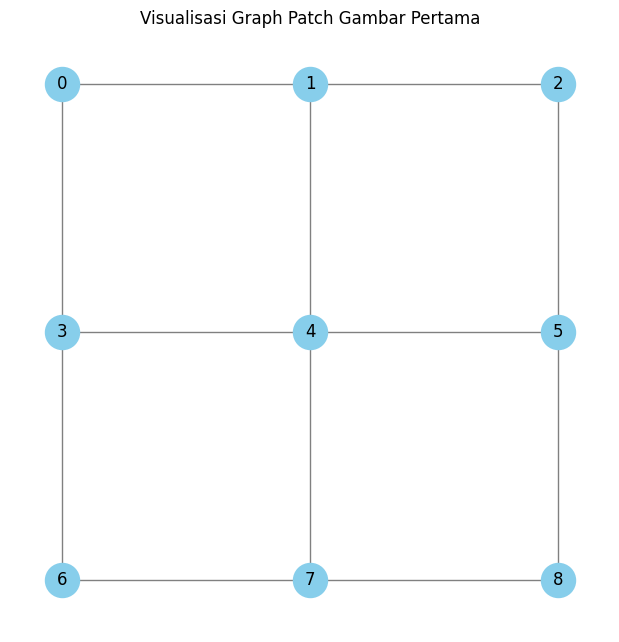

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import torch
import pandas as pd
import ast

# === 1. Baca CSV dan ambil data gambar pertama ===
df = pd.read_csv("graph_dataset_with_color_moment.csv")
edge_index = torch.tensor(ast.literal_eval(df.loc[0, "Edge_Index"]))
W, H = int(df.loc[0, "W"]), int(df.loc[0, "H"])  # untuk layout grid

# === 2. Buat graph dari edge_index ===
G = nx.Graph()
edges = edge_index.t().tolist()
G.add_edges_from(edges)

# === 3. Buat layout posisi node (grid visual) ===
pos = {}
for i in range(W * H):
    x = i % W
    y = - (i // W)  # supaya visual turun ke bawah
    pos[i] = (x, y)

# === 4. Gambar Graph ===
plt.figure(figsize=(6, 6))
nx.draw(G, pos, with_labels=True, node_color="skyblue", edge_color="gray", node_size=600)
plt.title("Visualisasi Graph Patch Gambar Pertama")
plt.axis('off')
plt.show()
